**Автор: Анна Смелова**

## Курсовая работа по теме "Regression. Tutors - expected math exam results" 
### Geekbrains Algorithms for analyze data. Predict average math exam results for students of the tutors
https://www.kaggle.com/c/regression-tutors-expected-math-exam-results

**Материалы к проекту (файлы):**
train.csv, 
test.csv

**Задание:**
Предсказать средний балл на экзамене по математике, который получают ученики репетиторов из датасета test.csv

**Целевая переменная:**
mean_exam_points

**Основная метрика:**
The evaluation metric is Coefficient of determination:

$R^2=1−\frac{σ^2}{σ^2_y}$

**Пороговое значение метрики:**
linear_regression 0.68533

**Ограничения:**
You can only use these imports:<br>
<font color='green'>
import numpy as np<br>
import pandas as pd<br>
from sklearn.model_selection import train_test_split<br>
import matplotlib.pyplot as plt<br>
import seaborn as sns<br></font>

## Шаг 1: Подготовка инструментов

### 1.1 Необходимые модули

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1.2 Загрузка данных

Загрузим тренировочные данные в переменную **train_data**, тестовые данные в переменную **test_data**

In [2]:
train_data_base=pd.read_csv('regression-tutors-expected-math-exam-results/train.csv')
train_data=train_data_base.copy()
train_data.shape

(10000, 12)

In [3]:
test_data_base=pd.read_csv('regression-tutors-expected-math-exam-results/test.csv')
test_data=test_data_base.copy()
test_data.shape

(10000, 11)

### 1.3 Необходимые классы и функции

In [4]:
def plot_scatter(title, data, x, y, color='b'):
    pd_scatter_plot = data.plot(y=y, x=x, kind='scatter', title=title, color=color)
    pd_scatter_plot.set_xlabel(x)
    pd_scatter_plot.set_ylabel(y)

In [5]:
def plot_boxplot(title, train_data, test_data):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.box(True)
    plt.grid()
    my_pal = {'Train': 'LightGreen', 'Test': 'LightYellow'}
    df = pd.DataFrame({'Train' : train_data, 'Test' : test_data})
    sns.boxplot(x='value', y='variable', data=pd.melt(df), palette=my_pal)
    plt.show()

In [6]:
def plot_hist(title, train_data, test_data):
    plt.figure(figsize=(10,5))
    plt.xlabel(title)
    plt.grid()
    plt.hist(train_data, bins=15, density=False, label='Train', alpha=0.5, color='green')
    plt.hist(test_data, bins=15, density=False, label='Test', alpha=0.5, color='yellow')
    plt.legend()
    plt.show()

In [7]:
def mean_squared_error(y_real, prediction):
        return (sum((y_real - prediction)**2)) / len(y_real)

In [8]:
def r2_score(y_real, prediction):
    numerator = ((y_real - prediction) ** 2).sum(axis=0, dtype=np.float64)
    denominator = ((y_real - np.average(y_real)) ** 2).sum(axis=0,
                                                          dtype=np.float64)
    return 1 - (numerator / denominator)

Стохастический градиентный спуск

In [9]:
# Класс для стохастического градиентного спуска
class StochasticGradientDescent:
    
    def __init__(self, eta=0.01, max_iter = 1e5, min_weight_dist = 1e-8, reg_type = 'l2', reg = 1e-8):
        self.eta = eta
        self.max_iter = max_iter
        self.min_weight_dist = min_weight_dist
        self.reg_type = reg_type
        self.reg = reg
        self.weights = []
        self.w = []
        self.errors = []
        
    # реализуем функцию, определяющую среднеквадратичную ошибку
    def mserror(self, X, w, y_pred):
        y = X.dot(w)
        return (sum((y - y_pred)**2)) / len(y)
        
    def fit(self, X, y):
        #добавим в матрицу признаков столбец из 1 для коэфициента интерсепта
        X=np.append(X, np.ones((X.shape[0],1)),1)
        
        # инициализируем начальный вектор весов
        self.w = np.zeros(X.shape[1])

        # список векторов весов после каждой итерации
        w_list = [self.w.copy()]

        # список значений ошибок после каждой итерации
        errors = []

        # зададим начальную разницу весов большим числом
        weight_dist = np.inf

        # счетчик итераций
        iter_num = 0

        np.random.seed(1234)

        # ход градиентного спуска
        while weight_dist > self.min_weight_dist and iter_num < self.max_iter:

            # генерируем случайный индекс объекта выборки
            train_ind = np.random.randint(X.shape[0], size=1)

            y_pred = np.dot(X[train_ind], self.w)
            
            dQ = 2/y[train_ind].shape[0] * np.dot(X[train_ind].T, y_pred - y[train_ind]) # градиент функции ошибки
            if self.reg_type == 'l2':
                dReg = self.reg * self.w # градиент регуляризации
            else:
                dReg = self.reg * np.sign(self.w)
            
            new_w = self.w - self.eta * dQ + dReg

            weight_dist = np.linalg.norm(new_w - self.w, ord=2)

            error = self.mserror(X, new_w, y)

            w_list.append(new_w.copy())
            errors.append(error)

            iter_num += 1
            self.w = new_w

        w_list = np.array(w_list)
        self.weights = w_list.copy()
        self.errors = errors


        return self
    
    def predict(self, X):
        X=np.append(X, np.ones((X.shape[0],1)),1)
        y_pred=np.dot(self.w, X.T)
       
        return y_pred.T

Случайный лес

In [10]:
# Класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [11]:
#Класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
          
    def predict(self):    
        prediction = np.mean(self.labels)
        return prediction       

In [12]:
# Класс дерева
class Tree_rf:
    
    def __init__(self, max_depth=100): 
        
        self.max_depth = max_depth
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.tree = None
        
    
    
    # Расчет среднеквадратичного отклонения
    def dispersion(self, labels):
        mean = labels.mean()
        return np.mean((labels - mean)**2)
    
    # Расчет прироста
    def gain(self, left_labels, right_labels, root_dispersion):
        # доля выборки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        
        gain = root_dispersion - p * self.dispersion(left_labels) - (1 - p) * self.dispersion(right_labels)
        
        return gain

    # Разбиение датасета в узле
    def split(self, data, labels, column_index, t):

        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Реализуем генерацию подмножества признаков для нахождения разбиения в узле
    def get_subsample(self, len_sample):
         # будем сохранять не сами признаки, а их индексы
        sample_indexes = list(range(len_sample))

        len_subsample = int(np.sqrt(len_sample))

        subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

        return subsample
    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):
        #  обозначим минимальное количество объектов в узле
        min_samples_leaf = 5

        root_dispersion = self.dispersion(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        feature_subsample_indices = self.get_subsample(n_features) # выбираем случайные признаки

        for index in feature_subsample_indices:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([obj[index] for obj in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                    continue

                current_gain = self.gain(true_labels, false_labels, root_dispersion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index
    
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels, depth, max_depth):

        gain, t, index = self.find_best_split(data, labels)
        
        #  Базовый случай 1 - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            #print('Base1')
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
 
        #  Базовый случай 2 - прекращаем рекурсию, когда достигли максимальной глубины дерева
        if depth >= max_depth:
            #print('Base2')
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)

        depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, depth, max_depth)
        false_branch = self.build_tree(false_data, false_labels, depth, max_depth)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node(index, t, true_branch, false_branch))
        return Node(index, t, true_branch, false_branch)
    
    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels, 0, self.max_depth)
        return self
    
    def predict(self, data):
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            classes.append(prediction)
        return classes

In [13]:
# Класс леса
class RandomForest:
    def __init__(self, n_trees, # количествоо деревьев 
                 max_depth=100): # максимальная глубина деревьев
    
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.forest = [] 
        self.train_mse = []
        self.test_mse = []
        self.train_r2 = []
        self.test_r2 = []
    
    # Реализуем генерацию 𝑁 бутстрап-выборок
    def get_bootstrap(self, data, labels, N):
        n_samples = data.shape[0] # размер совпадает с исходной выборкой
        bootstrap = []

        for i in range(N):
            sample_index = np.random.randint(0, n_samples, size=n_samples)
            b_data = data[sample_index]
            b_labels = labels[sample_index]

            bootstrap.append((b_data, b_labels))

        return bootstrap
    
    def fit(self, data, labels, valid_data, valid_labels, get_err=False):
        forest = []
        bootstrap = self.get_bootstrap(data, labels, self.n_trees)

        i = 1
        for b_data, b_labels in bootstrap:
            print(i, end=' ')
            new_tree = Tree_rf(max_depth=self.max_depth)
            new_tree.fit(b_data, b_labels)
            self.forest.append(new_tree)
            i+=1
            
            if get_err:
            
                train_labels_pred = self.tree_vote(data)
                test_labels_pred = self.tree_vote(valid_data)
                train_mse = mean_squared_error(labels, train_labels_pred)
                test_mse = mean_squared_error(valid_labels, test_labels_pred)
                train_r2 = r2_score(labels, train_labels_pred)
                test_r2 = r2_score(valid_labels, test_labels_pred)

                self.train_mse.append(train_mse)
                self.test_mse.append(test_mse)
                self.train_r2.append(train_r2)
                self.test_r2.append(test_r2)

        return self

    # предсказание голосованием деревьев
    def tree_vote(self, data):
        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self.forest:
            tree_vote = tree.predict(data)
            predictions.append(tree_vote)
            
        voted_predictions = np.mean(np.vstack((predictions)), axis=0)

        return voted_predictions

Стохастический градиентный бустинг

In [14]:
# Класс дерева
class Tree:
    
    def __init__(self, max_depth=100): 
        
        self.max_depth = max_depth
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.tree = None
        
    
    
    # Расчет среднеквадратичного отклонения
    def dispersion(self, labels):
        mean = labels.mean()
        return np.mean((labels - mean)**2)
    
    # Расчет прироста
    def gain(self, left_labels, right_labels, root_dispersion):
        # доля выборки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        
        gain = root_dispersion - p * self.dispersion(left_labels) - (1 - p) * self.dispersion(right_labels)
        
        return gain

    # Разбиение датасета в узле
    def split(self, data, labels, column_index, t):

        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Реализуем генерацию подмножества признаков для нахождения разбиения в узле
    def get_subsample(self, len_sample):
         # будем сохранять не сами признаки, а их индексы
        sample_indexes = list(range(len_sample))

        len_subsample = int(np.sqrt(len_sample))

        subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

        return subsample
    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):
        #  обозначим минимальное количество объектов в узле
        min_samples_leaf = 5

        root_dispersion = self.dispersion(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        feature_subsample_indices = self.get_subsample(n_features) # выбираем случайные признаки

        for index in feature_subsample_indices:
        #for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            #t_values = np.unique(data[:, index])
            t_values = np.unique([obj[index] for obj in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                    continue

                current_gain = self.gain(true_labels, false_labels, root_dispersion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index
    
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels, depth, max_depth):

        gain, t, index = self.find_best_split(data, labels)
        
        #  Базовый случай 1 - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            #print('Base1')
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
 
        #  Базовый случай 2 - прекращаем рекурсию, когда достигли максимальной глубины дерева
        if depth >= max_depth:
            #print('Base2')
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)

        depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, depth, max_depth)
        false_branch = self.build_tree(false_data, false_labels, depth, max_depth)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node(index, t, true_branch, false_branch))
        return Node(index, t, true_branch, false_branch)
    
    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels, 0, self.max_depth)
        return self
    
    def predict(self, data):
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            classes.append(prediction)
        return classes

In [15]:
# Класс для стохастического градиентного бустинга
class StochasticGradientBoosting:
    
    def __init__(self, n_trees, 
                 max_depth=100,
                 eta = 1,
                 size = 1):
        
        self.n_trees = n_trees #число деревьев в ансабле
        self.max_depth = max_depth #ограничение максимальной глубины деревьев в ансабле
        self.eta =eta # шаг градиентного бустинга
        self.trees_list = [] #список деревьев в ансабле 
        self.trees_predicts=[]
        self.size = size #размер подвыборки(доля)
        self.train_mse = []
        self.test_mse = []
        self.train_r2 = []
        self.test_r2 = []
        
    # Функция, реализующая предсказание в градиентном бустинге
    def predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
        # прибавляются с шагом eta
        
        predictions = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            prediction = 0
            for alg in self.trees_list:
                prediction += self.eta * alg.predict([x])[0]
            predictions[i] = prediction

        return predictions
    
    # В качестве функционала ошибки будем использовать среднеквадратичную ошибку
    def mean_squared_error(self, y_real, prediction):
        return (sum((y_real - prediction)**2)) / len(y_real)
    
    def residual(self, y, z):
        return (y - z)
    
    # Функция обучения градиентного бустинга
    def fit(self, X_train, y_train, X_valid, y_valid, get_err=False):
        # Деревья будем записывать в список
        self.trees_list = []

        for i in range(self.n_trees):
            print(i, end=' ')
            # Каждую итерацию учим на новой подвыборке
            train_ind = np.random.randint(X_train.shape[0], size=int(self.size*X_train.shape[0]))
            X_train_sub = X_train[train_ind]
            y_train_sub = y_train[train_ind]
            
            tree = Tree(max_depth=self.max_depth)

            # первый алгоритм просто обучаем на подвыборке и добавляем в список
            if len(self.trees_list) == 0:
                # обучаем первое дерево на обучающей подвыборке
                tree.fit(X_train_sub, y_train_sub)
            else:
                # Получим ответы на текущей композиции
                target = self.predict(X_train_sub)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train_sub, self.residual(y_train_sub, target))

            self.trees_list.append(tree)
            
            if get_err and i>30:
            
                train_labels_pred = self.predict(X_train)
                test_labels_pred = self.predict(X_valid)
                train_mse = mean_squared_error(y_train, train_labels_pred)
                test_mse = mean_squared_error(y_valid, test_labels_pred)
                train_r2 = r2_score(y_train, train_labels_pred)
                test_r2 = r2_score(y_valid, test_labels_pred)

                self.train_mse.append(train_mse)
                self.test_mse.append(test_mse)
                self.train_r2.append(train_r2)
                self.test_r2.append(test_r2)

        return self.trees_list

In [16]:
def plot_errors(a_trees, train_r2, test_r2, train_mse, test_mse):
    plt.figure(figsize=(16,7))
    
    plt.subplot(1,2,1)
    plt.plot(a_trees, train_r2, c='green', label='Train')
    plt.plot(a_trees, test_r2, c='red', label='Test')
    plt.xlabel('Количество деревьев')
    plt.ylabel('R2')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(a_trees, train_mse, c='LightGreen', label='Train')
    plt.plot(a_trees, test_mse, c='coral', label='Test')
    plt.xlabel('Количество деревьев')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

**Проверка моделей на синтетических данных**

In [17]:
from sklearn.datasets import make_regression
# сгенерируем линейный набор данных с шумом
X1, Y1 = make_regression(n_samples=300, n_features=7, n_informative=5, 
                         n_targets=1, noise=7, coef=False, random_state=9)

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X1, Y1, test_size=0.3, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(210, 7) (90, 7) (210,) (90,)


In [19]:
%%time
n_iterations = 10000
eta = 0.01
sgd = StochasticGradientDescent(max_iter=n_iterations, eta=eta, reg=0.001)
sgd.fit(X_train, y_train)
test_pred = sgd.predict(X_valid)
train_pred = sgd.predict(X_train)
r2_train_sgd = r2_score(y_train, train_pred)
r2_test_sgd = r2_score(y_valid, test_pred)

print(f'R2 score TRAIN {r2_train_sgd}')
print(f'R2 score VALID {r2_test_sgd}')
print(f'MSE TRAIN {mean_squared_error(y_train, train_pred)}')
print(f'MSE VALID {mean_squared_error(y_valid, test_pred)}')

R2 score TRAIN 0.9953608059240894
R2 score VALID 0.994435392301576
MSE TRAIN 89.03467832443779
MSE VALID 87.06873247013942
CPU times: user 1.49 s, sys: 31.9 ms, total: 1.53 s
Wall time: 1.82 s


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 R2 score TRAIN 0.9100754828499642
R2 score VALID 0.7692843435870071
MSE TRAIN 1725.817098169642
MSE VALID 3609.979508633587


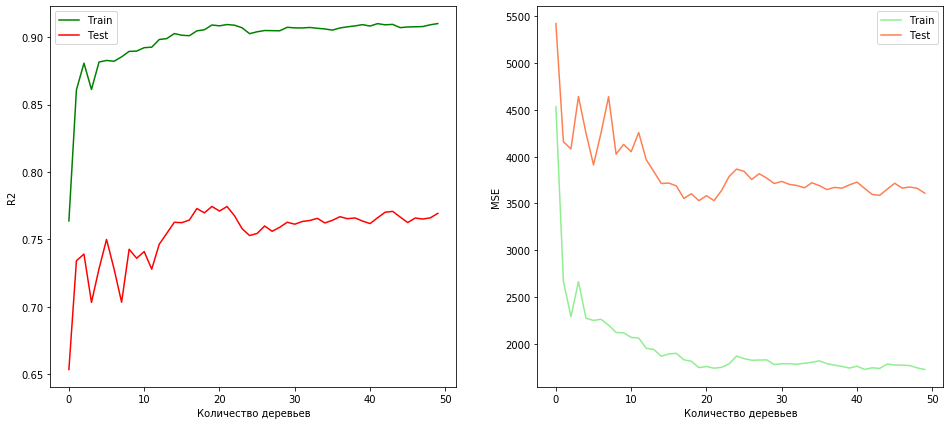

CPU times: user 7.66 s, sys: 108 ms, total: 7.77 s
Wall time: 8.56 s


In [20]:
%%time
n_trees = 50
max_depth = 10
forest = RandomForest(n_trees=n_trees, max_depth=max_depth)
forest.fit(X_train, y_train, X_valid, y_valid, get_err=True) 
train_predictions_f = forest.tree_vote(X_train)
valid_predictions_f = forest.tree_vote(X_valid)
r2_train_f = r2_score(y_train, train_predictions_f)
r2_test_f = r2_score(y_valid, valid_predictions_f)
        
print(f'R2 score TRAIN {r2_train_f}')
print(f'R2 score VALID {r2_test_f}')
print(f'MSE TRAIN {mean_squared_error(y_train, train_predictions_f)}')
print(f'MSE VALID {mean_squared_error(y_valid, valid_predictions_f)}')
plot_errors(list(range(n_trees)), forest.train_r2, forest.test_r2, forest.train_mse, forest.test_mse)           

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 R2 score TRAIN 0.8906084542481545
R2 score VALID 0.7946308870017877
MSE TRAIN 2099.4252294816624
MSE VALID 3213.3852602646807


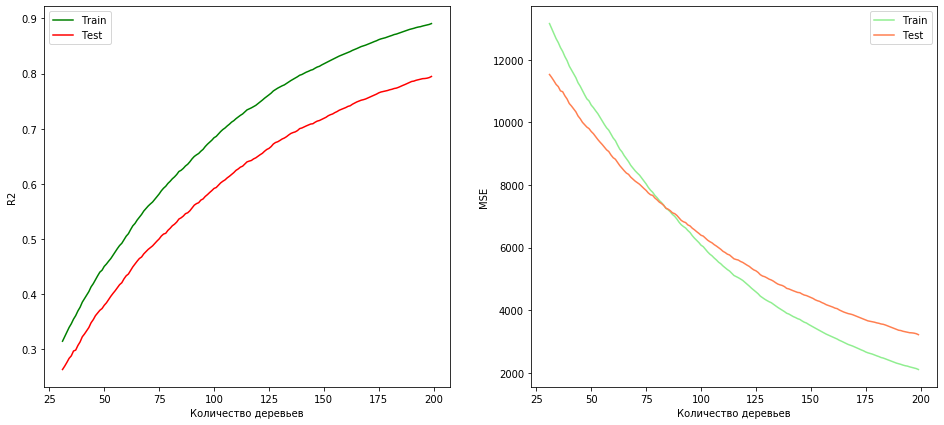

CPU times: user 37.7 s, sys: 274 ms, total: 38 s
Wall time: 38.7 s


In [21]:
%%time
n_trees = 200
max_depth = 5
eta = 0.01
sboosting = StochasticGradientBoosting(n_trees=n_trees, max_depth=max_depth, eta=eta, size=0.5)
sboosting.fit(X_train, y_train, X_valid, y_valid, get_err=True) 
train_predictions_sgb = sboosting.predict(X_train)
valid_predictions_sgb = sboosting.predict(X_valid)
r2_train_sgb = r2_score(y_train, train_predictions_sgb)
r2_test_sgb = r2_score(y_valid, valid_predictions_sgb)
        
print(f'R2 score TRAIN {r2_train_sgb}')
print(f'R2 score VALID {r2_test_sgb}')
print(f'MSE TRAIN {mean_squared_error(y_train, train_predictions_sgb)}')
print(f'MSE VALID {mean_squared_error(y_valid, valid_predictions_sgb)}')
plot_errors(list(range(31,n_trees)), sboosting.train_r2, sboosting.test_r2, sboosting.train_mse, sboosting.test_mse)

## Шаг 2: Подготовка данных

In [22]:
train_data.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,61
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,76
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57


In [23]:
test_data.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
0,10000,46.0,3.0,1050.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,10001,43.0,3.0,1850.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10002,52.0,1.0,1550.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10003,57.0,6.0,2900.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0
4,10004,44.0,4.0,3150.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0


### 2.1 Обработка пропущенных значений и выбросов в данных

In [24]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,4999.5000,2886.895680,0.0,2499.75,4999.5,7499.25,9999.0
age,10000.0,45.8780,8.043929,23.0,40.00,46.0,51.00,68.0
years_of_experience,10000.0,1.9868,1.772213,0.0,0.00,2.0,3.00,10.0
lesson_price,10000.0,1699.1050,524.886654,200.0,1300.00,1500.0,2150.00,3950.0
qualification,10000.0,1.7195,0.792264,1.0,1.00,2.0,2.00,4.0
physics,10000.0,0.3750,0.484147,0.0,0.00,0.0,1.00,1.0
chemistry,10000.0,0.1329,0.339484,0.0,0.00,0.0,0.00,1.0
biology,10000.0,0.1096,0.312406,0.0,0.00,0.0,0.00,1.0
english,10000.0,0.0537,0.225436,0.0,0.00,0.0,0.00,1.0
geography,10000.0,0.0321,0.176274,0.0,0.00,0.0,0.00,1.0


In [25]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,14999.5000,2886.895680,10000.0,12499.75,14999.5,17499.25,19999.0
age,10000.0,45.9728,7.956280,23.0,41.00,46.0,51.00,68.0
years_of_experience,10000.0,1.9800,1.783289,0.0,0.00,2.0,3.00,10.0
lesson_price,10000.0,1697.0950,524.262621,200.0,1300.00,1500.0,2150.00,4050.0
qualification,10000.0,1.7094,0.793483,1.0,1.00,2.0,2.00,4.0
physics,10000.0,0.3813,0.485730,0.0,0.00,0.0,1.00,1.0
chemistry,10000.0,0.1235,0.329027,0.0,0.00,0.0,0.00,1.0
biology,10000.0,0.1201,0.325095,0.0,0.00,0.0,0.00,1.0
english,10000.0,0.0560,0.229933,0.0,0.00,0.0,0.00,1.0
geography,10000.0,0.0314,0.174405,0.0,0.00,0.0,0.00,1.0


Пропусков в данных нет.<br>
Выбросов в данных также не видно. Но, на всякий случай посмотрим более детально на признак "lesson_price".

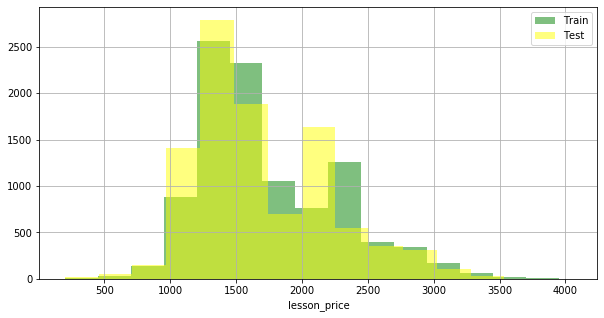

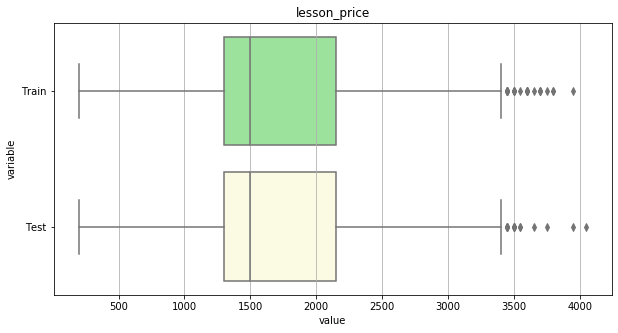

In [26]:
plot_hist('lesson_price', train_data['lesson_price'], test_data['lesson_price'])
plot_boxplot('lesson_price', train_data['lesson_price'], test_data['lesson_price'])

Значения, которые превышают 3400 можно считать выбросами. Но, так как они есть и в тренировочной выборке и в тестовой, не будем удалять их.

### 2.2 Поиск взаимосвязей между признаками

Разделим признаки на количественные, ранговые и категориальные (признак "Id" пока добавим в ранговые, а потом уберем, т.к. он неинформативный, признак "age" добавим в количественные):

In [27]:
cat_features = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']
rank_features = ['Id', 'years_of_experience', 'qualification']
num_features = ['age', 'lesson_price', 'mean_exam_points']

In [28]:
train_data_num = train_data[num_features]
train_data_rank = train_data[rank_features]
train_data_cat = train_data[cat_features]

test_data_num = test_data[num_features[:-1]]
test_data_rank = test_data[rank_features]
test_data_cat = test_data[cat_features]

Для количественных признаков посмотрим на матрицу корреляции.

In [29]:
corr_features = num_features
corr = train_data[corr_features].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,lesson_price,mean_exam_points
age,1,-0.0055,-0.0071
lesson_price,-0.0055,1,0.66
mean_exam_points,-0.0071,0.66,1


Между признаком lesson_price и целевым mean_exam_points довольно высокая корреляция. Посмотрим на графике.

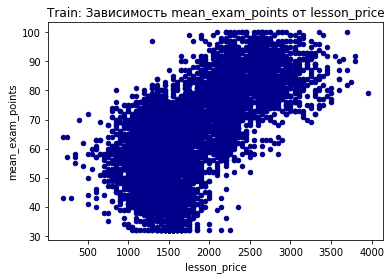

In [30]:
plot_scatter('Train: Зависимость mean_exam_points от lesson_price', train_data, 'lesson_price', 'mean_exam_points','DarkBlue')

Видна тенденция, но четкая зависимость не прослеживается.

Для категориальных и ранговых признаков псмотрим на взаимную информацию между признаками и целевой переменной.<br>
Сначала разделим признаки тренировочной выборки на непосредственно признаки и на целевую переменную. Признак "Id" неинформативный - тоже выделим его в отдельную переменную.

In [31]:
target = train_data_num['mean_exam_points']
train_ids = train_data_rank['Id'].astype('int64')
train_num = train_data_num.drop(['mean_exam_points'],axis=1)
train_rank = train_data_rank.drop(['Id'],axis=1)
train_cat = train_data_cat

Для подсчета взаимной информации надо, чтобы признак был дискретным.

In [32]:
from sklearn.metrics.cluster import contingency_matrix
def get_mi(x, y):
    mi = 0
    cm = contingency_matrix(y, x)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            size = np.sum(cm)
            p_x_y = cm[i][j] / size
            p_x = np.sum(cm[:, j]) / size
            p_y = np.sum(cm[i]) / size

            if p_x_y == 0:
                continue
            mi += p_x_y * np.log(p_x_y / (p_x * p_y))
    return mi

In [33]:
for cat in train_cat.columns:
    print(f'Взаимная информация признака {cat} с целевой переменной {get_mi(train_cat[cat], target)}')

Взаимная информация признака physics с целевой переменной 0.020431655707399007
Взаимная информация признака chemistry с целевой переменной 0.003447452641455157
Взаимная информация признака biology с целевой переменной 0.0035238103190213268
Взаимная информация признака english с целевой переменной 0.004333325070412127
Взаимная информация признака geography с целевой переменной 0.0030148939876254947
Взаимная информация признака history с целевой переменной 0.003873674626379325


In [34]:
for cat in train_rank.columns:
    print(f'Взаимная информация признака {cat} с целевой переменной {get_mi(train_rank[cat], target)}')

Взаимная информация признака years_of_experience с целевой переменной 0.06100379673634039
Взаимная информация признака qualification с целевой переменной 0.3691424927915336


Выделяются признаки "qualification", "years_of_experience" и "physics".

### 2.3 Добавление новых признаков

#### 2.3.1 Суммарное количество предметов помимо математики у преподавателя

In [35]:
train_subjects = train_data[['physics','chemistry','biology','english','geography','history']].sum(axis=1) 
train_data['subjects_num'] = train_subjects

test_subjects = test_data[['physics','chemistry','biology','english','geography','history']].sum(axis=1) 
test_data['subjects_num'] = test_subjects

rank_features.append('subjects_num') # это ранговый признак

print(train_data['subjects_num'].value_counts())
print(test_data['subjects_num'].value_counts())

0.0    4377
1.0    4197
2.0    1256
3.0     162
4.0       8
Name: subjects_num, dtype: int64
0.0    4319
1.0    4244
2.0    1258
3.0     170
4.0       8
5.0       1
Name: subjects_num, dtype: int64


Получилось, что на тесте есть один преподаватель, у которого 5 предметов. Заменим значение на 4, и будем воспринимать этот показатель, как $\geq4$

In [36]:
test_data.loc[test_data['subjects_num']==5,'subjects_num']=4
print(test_data['subjects_num'].value_counts())

0.0    4319
1.0    4244
2.0    1258
3.0     170
4.0       9
Name: subjects_num, dtype: int64


#### 2.3.2 Скорость достижения квалификации

In [37]:
train_qual_speed = train_data['qualification'] / train_data['age']
train_data['qual_speed'] = train_qual_speed

test_qual_speed = test_data['qualification'] / test_data['age']
test_data['qual_speed'] = test_qual_speed

num_features.append('qual_speed') # это количественный признак

#### 2.3.3 Преподаватель с высокой квалификацией

In [38]:
train_high_qualification = (train_data['qualification']>=3).astype('int64')
train_data['high_qualification'] = train_high_qualification

test_high_qualification = (test_data['qualification']>=3).astype('int64')
test_data['high_qualification'] = test_high_qualification

cat_features.append('high_qualification') # это категориальный признак

#### 2.3.4 Преподаватель в возрасте или молодой

In [39]:
train_old = (train_data['age']>train_data['age'].quantile(.75)).astype('int64')
train_data['old'] = train_old
train_young = (train_data['age']<train_data['age'].quantile(.25)).astype('int64')
train_data['young'] = train_young
train_data['med'] = [1] * train_data.shape[0]
train_data['med'] = train_data['med'] - train_data['young'] - train_data['old']

test_old = (test_data['age']>test_data['age'].quantile(.75)).astype('int64')
test_data['old'] = test_old
test_young = (test_data['age']<test_data['age'].quantile(.25)).astype('int64')
test_data['young'] = test_young
test_data['med'] = [1] * test_data.shape[0]
test_data['med'] = test_data['med'] - test_data['young'] - test_data['old']

cat_features.append('old') # это категориальный признак
cat_features.append('young') # это категориальный признак
cat_features.append('med') # это категориальный признак

#### 2.3.5 Дорогой или дешевый урок

In [40]:
train_expensive = (train_data['lesson_price']>train_data['lesson_price'].quantile(.75)).astype('int64')
train_data['expensive'] = train_expensive
train_cheap = (train_data['lesson_price']<train_data['lesson_price'].quantile(.25)).astype('int64')
train_data['cheap'] = train_cheap
train_data['ok'] = [1] * train_data.shape[0]
train_data['ok'] = train_data['ok'] - train_data['expensive'] - train_data['cheap']

test_expensive = (test_data['lesson_price']>test_data['lesson_price'].quantile(.75)).astype('int64')
test_data['expensive'] = test_expensive
test_cheap = (test_data['lesson_price']<test_data['lesson_price'].quantile(.25)).astype('int64')
test_data['cheap'] = test_cheap
test_data['ok'] = [1] * test_data.shape[0]
test_data['ok'] = test_data['ok'] - test_data['expensive'] - test_data['cheap']

cat_features.append('expensive') # это категориальный признак
cat_features.append('cheap') # это категориальный признак
cat_features.append('ok') # это категориальный признак

#### 2.3.6 Опытный физик

In [41]:
train_exp_physic = train_data['physics'] * train_data['years_of_experience']
train_data['exp_physic'] = train_exp_physic

test_exp_physic = test_data['physics'] * test_data['years_of_experience']
test_data['exp_physic'] = test_exp_physic

num_features.append('exp_physic') # это количественный признак

Снова посмотрим на взаимосвязи между признаками.

In [42]:
corr_features = num_features
corr = train_data[corr_features].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,lesson_price,mean_exam_points,qual_speed,exp_physic
age,1,-0.0055,-0.0071,-0.37,0.025
lesson_price,-0.0055,1,0.66,0.72,0.1
mean_exam_points,-0.0071,0.66,1,0.64,0.2
qual_speed,-0.37,0.72,0.64,1,0.064
exp_physic,0.025,0.1,0.2,0.064,1


In [43]:
for cat in cat_features:
    print(f'Взаимная информация признака {cat} с целевой переменной {get_mi(train_data[cat], target)}')

Взаимная информация признака physics с целевой переменной 0.020431655707399007
Взаимная информация признака chemistry с целевой переменной 0.003447452641455157
Взаимная информация признака biology с целевой переменной 0.0035238103190213268
Взаимная информация признака english с целевой переменной 0.004333325070412127
Взаимная информация признака geography с целевой переменной 0.0030148939876254947
Взаимная информация признака history с целевой переменной 0.003873674626379325
Взаимная информация признака high_qualification с целевой переменной 0.2968819101235791
Взаимная информация признака old с целевой переменной 0.002441638001830324
Взаимная информация признака young с целевой переменной 0.0031403955610686644
Взаимная информация признака med с целевой переменной 0.003522534484999914
Взаимная информация признака expensive с целевой переменной 0.2563143810201615
Взаимная информация признака cheap с целевой переменной 0.08337577191687959
Взаимная информация признака ok с целевой перемен

In [44]:
for cat in rank_features[1:]:
    print(f'Взаимная информация признака {cat} с целевой переменной {get_mi(train_data[cat], target)}')

Взаимная информация признака years_of_experience с целевой переменной 0.06100379673634039
Взаимная информация признака qualification с целевой переменной 0.3691424927915336
Взаимная информация признака subjects_num с целевой переменной 0.024316259301802715


Из количественных признаков выделяются "lesson_price" и "qual_speed".<br>
Из категориальных признаков выделяются "high_qualification", "expensive", "cheap", "ok" и "physics".
Ранговые все относительно хорошие "years_of_experience", "qualification" и "subjects_num".

Остальные признаки удалим как неинформативные.

In [45]:
cat_features = ['physics', 'high_qualification', 'expensive', 'cheap', 'ok']
rank_features = ['years_of_experience', 'qualification', 'subjects_num']
num_features = ['lesson_price', 'qual_speed']
target_feature = 'mean_exam_points'
id_feature = ['Id']

In [46]:
train_num = train_data[num_features]
train_rank = train_data[rank_features]
train_cat = train_data[cat_features]
target = train_data[target_feature]
train_ids = train_data[id_feature]

test_num = test_data[num_features]
test_rank = test_data[rank_features]
test_cat = test_data[cat_features]
test_ids = test_data[id_feature]

### 2.4 Масштабирование признаков

Все категориальные признаки представляют из себя наборы из 0 и 1.

In [47]:
train_cat.describe()

,physics,high_qualification,expensive,cheap,ok
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.375000,0.202900,0.225400,0.212100,0.562500
std,0.484147,0.402179,0.417866,0.408816,0.496103
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


Всем ранговым признакам поставим в соответствие наборы из 0 и 1, используя для этого dummy-переменные:

In [48]:
for feature in train_rank.columns:
    train_rank[feature] = train_rank[feature].astype(object)
train_rank = pd.get_dummies(train_rank)
    
for feature in test_rank.columns:
    test_rank[feature] = test_rank[feature].astype(object)
test_rank = pd.get_dummies(test_rank)

print(train_rank.shape, test_rank.shape)

(10000, 20) (10000, 20)


/Users/annasmelova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
# Проверим, что полученные признаки совпадают
print(train_rank.columns == test_rank.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


In [50]:
train_rank.describe()

,years_of_experience_0.0,years_of_experience_1.0,years_of_experience_2.0,years_of_experience_3.0,years_of_experience_4.0,years_of_experience_5.0,years_of_experience_6.0,years_of_experience_7.0,years_of_experience_8.0,years_of_experience_9.0,years_of_experience_10.0,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0,subjects_num_0.0,subjects_num_1.0,subjects_num_2.0,subjects_num_3.0,subjects_num_4.0
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,0.278500,0.175700,0.18040,0.157200,0.112200,0.05840,0.028200,0.007000,0.002000,0.000300,0.0001,0.48840,0.30870,0.197900,0.005000,0.437700,0.419700,0.125600,0.01620,0.000800
std,0.448283,0.380584,0.38454,0.364007,0.315628,0.23451,0.165552,0.083377,0.044679,0.017319,0.0100,0.49989,0.46198,0.398436,0.070537,0.496128,0.493534,0.331415,0.12625,0.028274
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,1.00000,1.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.0000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


Отмасштабируем получившиеся количественные признаки методом нормализации.

In [51]:
# TRAIN
train_num_min = np.min(train_num, axis=0)
train_num_max = np.max(train_num, axis=0)

# TEST
test_num_min = np.min(test_num, axis=0)
test_num_max = np.max(test_num, axis=0)

#display(train_num_min, test_num_min, train_num_max, test_num_max)

In [52]:
train_num_d = train_num_max - train_num_min
test_num_d = test_num_max - test_num_min

train_num_norm = train_num.to_numpy(copy='True')
test_num_norm = test_num.to_numpy(copy='True')

# вычтем из каждого значения признака минимум и поделим на разность между максимумом и минимумом
for i in range(train_num_norm.shape[0]):
    for j in range(train_num_norm.shape[1]):
        train_num_norm[i][j] = (train_num_norm[i][j] - train_num_min[j]) / train_num_d[j]
        
for k in range(test_num_norm.shape[0]):
    for m in range(test_num_norm.shape[1]):
        test_num_norm[k][m] = (test_num_norm[k][m] - test_num_min[m]) / test_num_d[m]

In [53]:
# TRAIN
train_num_min = np.min(train_num_norm, axis=0)
train_num_max = np.max(train_num_norm, axis=0)

# TEST
test_num_min = np.min(test_num_norm, axis=0)
test_num_max = np.max(test_num_norm, axis=0)

display(train_num_min, test_num_min, train_num_max, test_num_max)

array([0., 0.])

array([0., 0.])

array([1., 1.])

array([1., 1.])

### 2.5 Объединение признаков

Объединим полученные признаки.

In [54]:
print(train_ids.columns)
print(train_num.columns)
print(train_cat.columns)
print(train_rank.columns)

Index(['Id'], dtype='object')
Index(['lesson_price', 'qual_speed'], dtype='object')
Index(['physics', 'high_qualification', 'expensive', 'cheap', 'ok'], dtype='object')
Index(['years_of_experience_0.0', 'years_of_experience_1.0',
       'years_of_experience_2.0', 'years_of_experience_3.0',
       'years_of_experience_4.0', 'years_of_experience_5.0',
       'years_of_experience_6.0', 'years_of_experience_7.0',
       'years_of_experience_8.0', 'years_of_experience_9.0',
       'years_of_experience_10.0', 'qualification_1.0', 'qualification_2.0',
       'qualification_3.0', 'qualification_4.0', 'subjects_num_0.0',
       'subjects_num_1.0', 'subjects_num_2.0', 'subjects_num_3.0',
       'subjects_num_4.0'],
      dtype='object')


In [55]:
features = list(train_num.columns) + list(train_cat.columns) + list(train_rank.columns)
print(features)

['lesson_price', 'qual_speed', 'physics', 'high_qualification', 'expensive', 'cheap', 'ok', 'years_of_experience_0.0', 'years_of_experience_1.0', 'years_of_experience_2.0', 'years_of_experience_3.0', 'years_of_experience_4.0', 'years_of_experience_5.0', 'years_of_experience_6.0', 'years_of_experience_7.0', 'years_of_experience_8.0', 'years_of_experience_9.0', 'years_of_experience_10.0', 'qualification_1.0', 'qualification_2.0', 'qualification_3.0', 'qualification_4.0', 'subjects_num_0.0', 'subjects_num_1.0', 'subjects_num_2.0', 'subjects_num_3.0', 'subjects_num_4.0']


In [56]:
train_norm = np.hstack((train_num_norm, train_cat, train_rank))

test_norm = np.hstack((test_num_norm, test_cat, test_rank))

### 2.6 Обучающая и валидационная выборки

Перемешивание датасета

In [57]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(train_norm.shape[0])
X, y = train_norm[shuffle_index], target[shuffle_index]

Разобьем тренировочные данные на обучающую и валидационную выборки.

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(7000, 27) (3000, 27) (7000,) (3000,)


In [60]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)

## Шаг 3: Подбор параметров модели

Будем подбирать параметры моделей и записывать адекватные результаты в датафрейм.

In [61]:
models_results = pd.DataFrame()
model_name = []
r2_train_result = []
r2_test_result = []
mse_train_result = []
mse_test_result = []
model_params = []

In [62]:
%%time
name = 'SGD'

a_reg_type = ['l1','l2']
a_max_iter = [1000, 5000]
a_reg = [0.1, 0.01, 0.001, 0.0001]
a_eta = [0.1, 0.05, 0.001]

for reg_type in a_reg_type:
    for max_iter in a_max_iter:
        for reg in a_reg:
            for eta in a_eta:
                params = [reg_type, max_iter, reg, eta]
                sgd = StochasticGradientDescent(max_iter=max_iter, reg_type=reg_type, reg=reg, eta=eta)
                sgd.fit(X_train, y_train)
                train_predictions_sgd = sgd.predict(X_train)
                valid_predictions_sgd = sgd.predict(X_valid)
                r2_train_sgd = r2_score(y_train, train_predictions_sgd)
                r2_test_sgd = r2_score(y_valid, valid_predictions_sgd)
                print(params, r2_test_sgd)
                if r2_test_sgd > 0.68533:
                    print(f'{params} ok')
                    model_name.append(name)
                    model_params.append(params)
                    r2_train_result.append(r2_train_sgd)
                    r2_test_result.append(r2_test_sgd)
                    mse_train_result.append(mean_squared_error(y_train, train_predictions_sgd))
                    mse_test_result.append(mean_squared_error(y_valid, valid_predictions_sgd))

['l1', 1000, 0.1, 0.1] -0.5859605576079456
['l1', 1000, 0.1, 0.05] -0.42375404619788704
['l1', 1000, 0.1, 0.001] -37.109931180517755
['l1', 1000, 0.01, 0.1] 0.06612662449165962
['l1', 1000, 0.01, 0.05] 0.358841759666948
['l1', 1000, 0.01, 0.001] 0.05878570592049104
['l1', 1000, 0.001, 0.1] 0.1000443349314385
['l1', 1000, 0.001, 0.05] 0.38379077621785973
['l1', 1000, 0.001, 0.001] 0.4798839707260326
['l1', 1000, 0.0001, 0.1] 0.10346570332725902
['l1', 1000, 0.0001, 0.05] 0.3855787445364611
['l1', 1000, 0.0001, 0.001] 0.45575705605787165
['l1', 5000, 0.1, 0.1] -0.49885268017033346
['l1', 5000, 0.1, 0.05] -2.1478537228962793
['l1', 5000, 0.1, 0.001] -70.23000099790637
['l1', 5000, 0.01, 0.1] 0.17696439670159092
['l1', 5000, 0.01, 0.05] 0.5001753031771375
['l1', 5000, 0.01, 0.001] -0.01708308050410512
['l1', 5000, 0.001, 0.1] 0.18926070498024194
['l1', 5000, 0.001, 0.05] 0.518195235985726
['l1', 5000, 0.001, 0.001] 0.5561613532716256
['l1', 5000, 0.0001, 0.1] 0.19164318232093225
['l1', 500

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


['l2', 5000, 0.1, 0.1] -inf
['l2', 5000, 0.1, 0.05] -inf
['l2', 5000, 0.1, 0.001] -inf
['l2', 5000, 0.01, 0.1] -1.5708024710266635e+36
['l2', 5000, 0.01, 0.05] -1.291714994732715e+37
['l2', 5000, 0.01, 0.001] -3.3955765214542306e+38
['l2', 5000, 0.001, 0.1] -0.30982413179537205
['l2', 5000, 0.001, 0.05] -0.36920538453627705
['l2', 5000, 0.001, 0.001] -13.086865446024891
['l2', 5000, 0.0001, 0.1] 0.18800433923332915
['l2', 5000, 0.0001, 0.05] 0.5178483356038434
['l2', 5000, 0.0001, 0.001] 0.548283539253348
CPU times: user 9min 41s, sys: 5.62 s, total: 9min 46s
Wall time: 5min 41s


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 [5] 0.6062387435920116


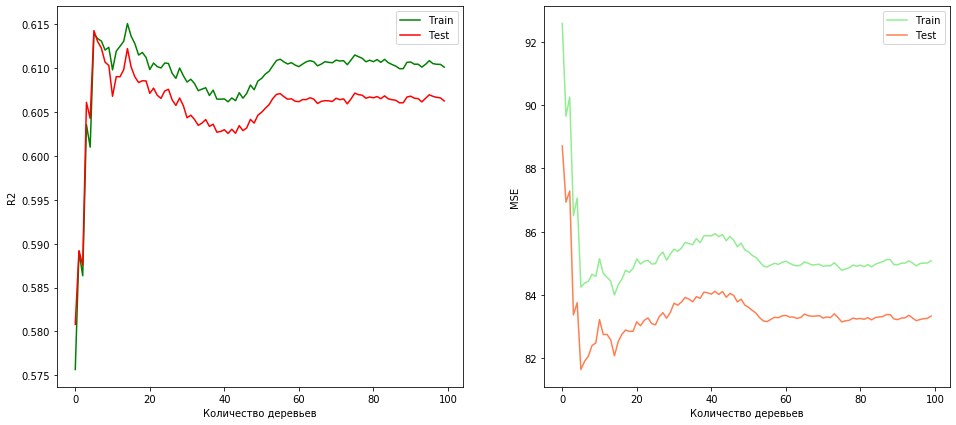

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 [10] 0.6404814533742249


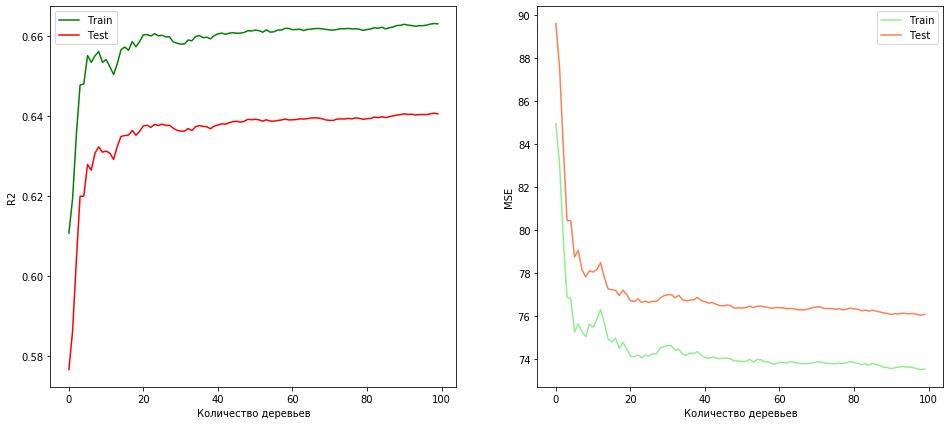

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 [100] 0.6440614944272232


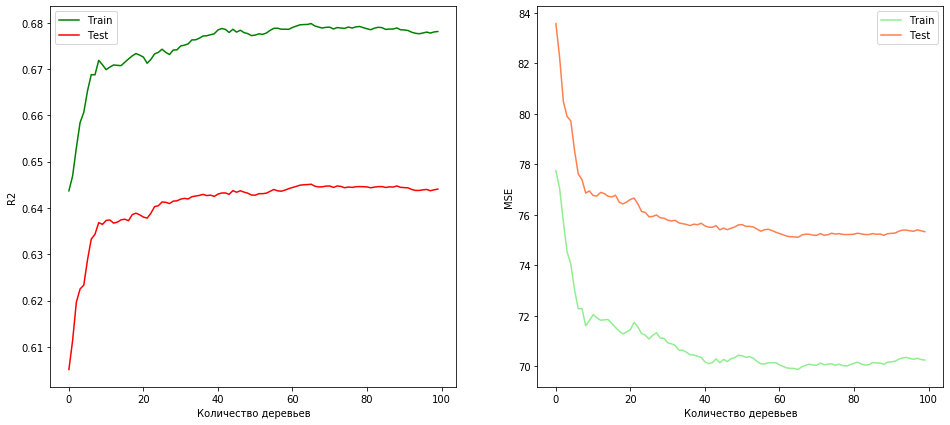

CPU times: user 28min 5s, sys: 18.4 s, total: 28min 24s
Wall time: 30min 9s


In [63]:
%%time
name = 'RF'

a_depths = [5, 10, 100]
n_trees = 100

for max_depth in a_depths:
    params = [max_depth]
    forest = RandomForest(n_trees=n_trees, max_depth=max_depth)
    forest.fit(X_train, y_train, X_valid, y_valid, get_err=True) 
    train_predictions_f = forest.tree_vote(X_train)
    valid_predictions_f = forest.tree_vote(X_valid)
    r2_train_f = r2_score(y_train, train_predictions_f)
    r2_test_f = r2_score(y_valid, valid_predictions_f)

    print(params, r2_test_f)
    if r2_test_f > 0.68533:
        print(f'{params} ok')
        model_name.append(name)
        model_params.append(params)
        r2_train_result.append(r2_train_f)
        r2_test_result.append(r2_test_f)
        mse_train_result.append(mean_squared_error(y_train, train_predictions_f))
        mse_test_result.append(mean_squared_error(y_valid, valid_predictions_f))
    plot_errors(list(range(n_trees)), forest.train_r2, forest.test_r2, forest.train_mse, forest.test_mse) 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 [5, 0.1] 0.644352867516352


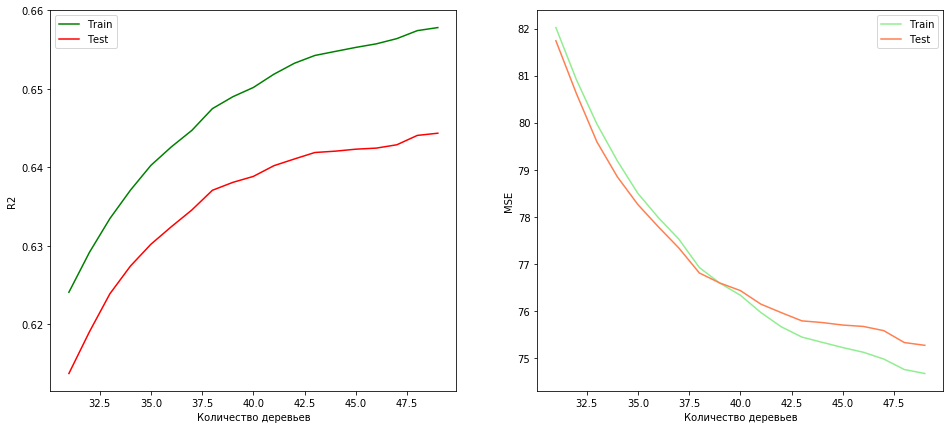

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 [5, 0.01] -6.647088485673376


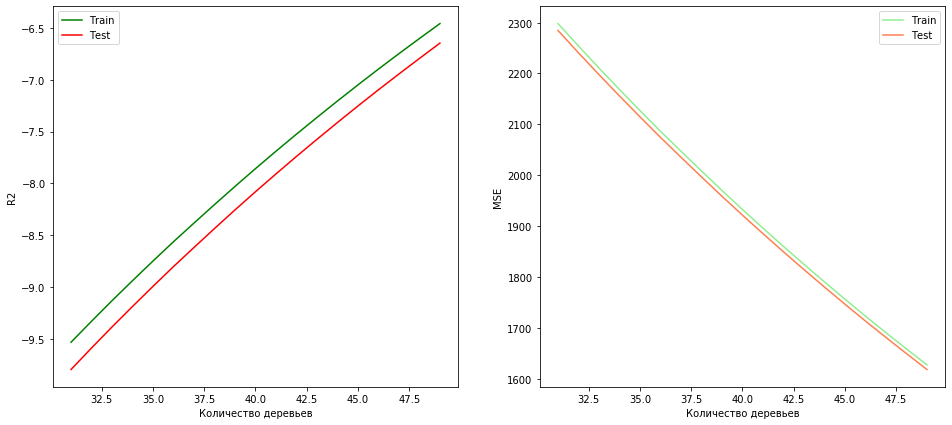

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 [5, 1] 0.5040488292128891


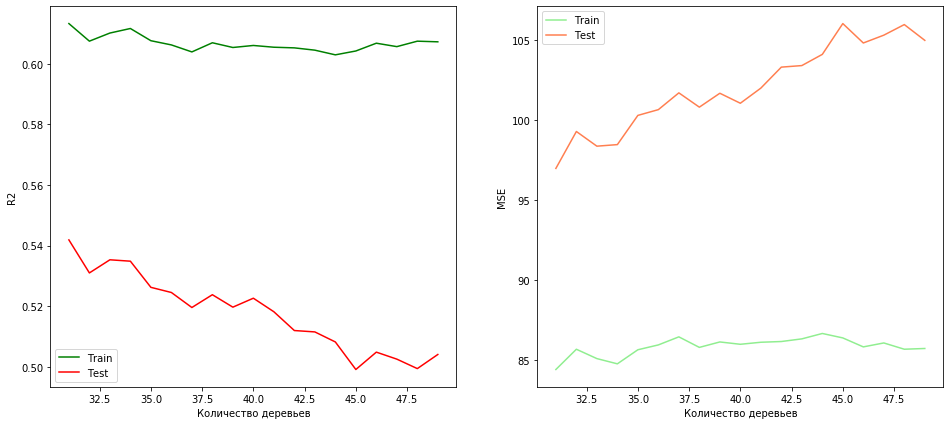

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 [10, 0.1] 0.6408250389013331


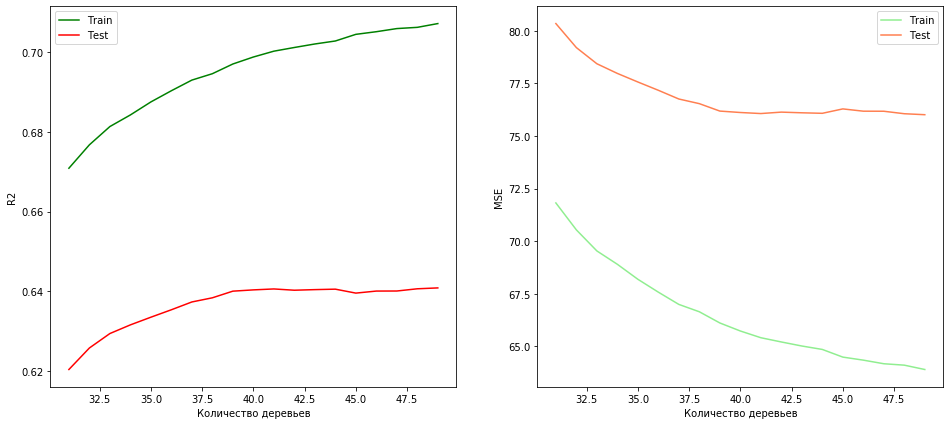

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 [10, 0.01] -6.6223374060901


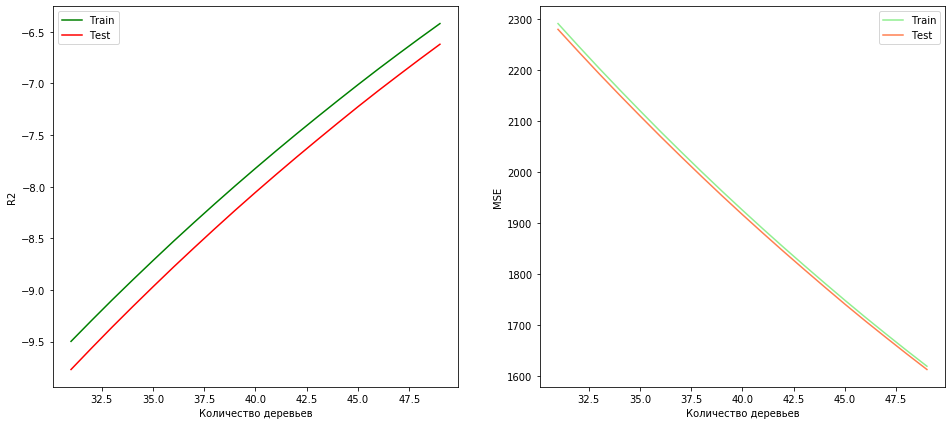

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 [10, 1] 0.005706114093705139


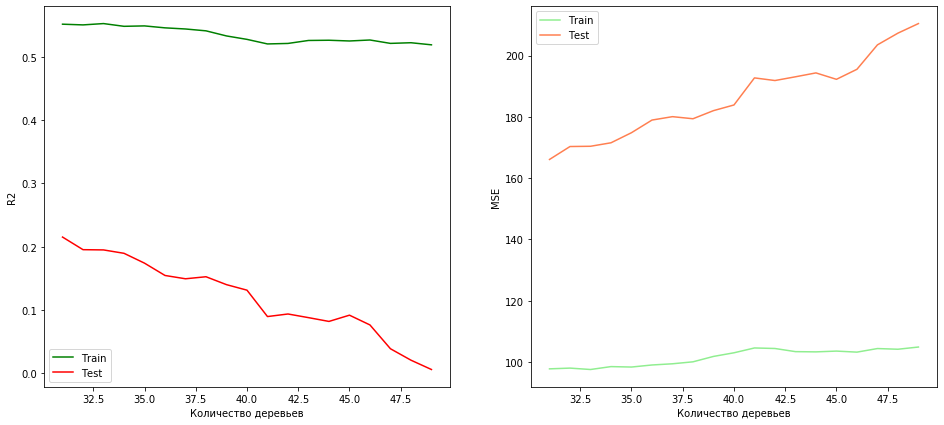

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 [100, 0.1] 0.6322439211336902


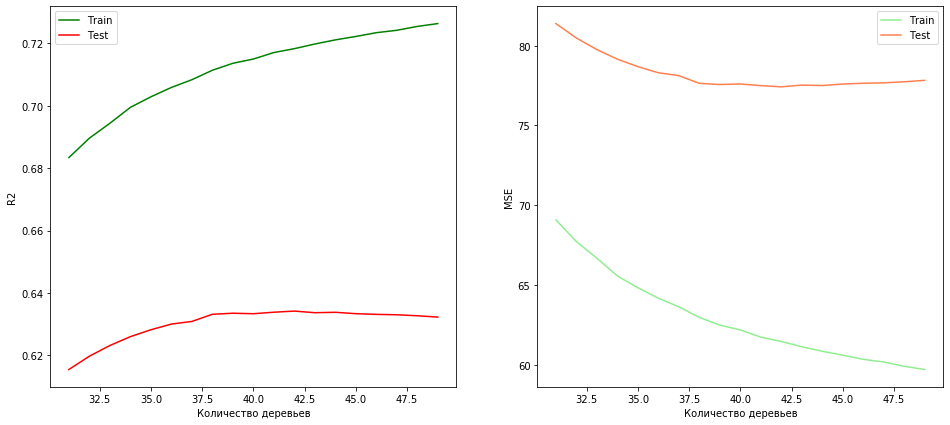

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 [100, 0.01] -6.617844987492945


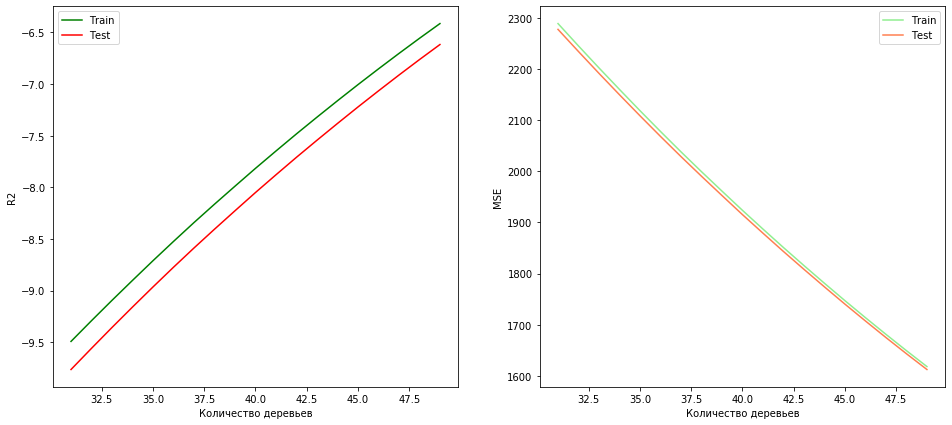

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 [100, 1] -0.31090472705837224


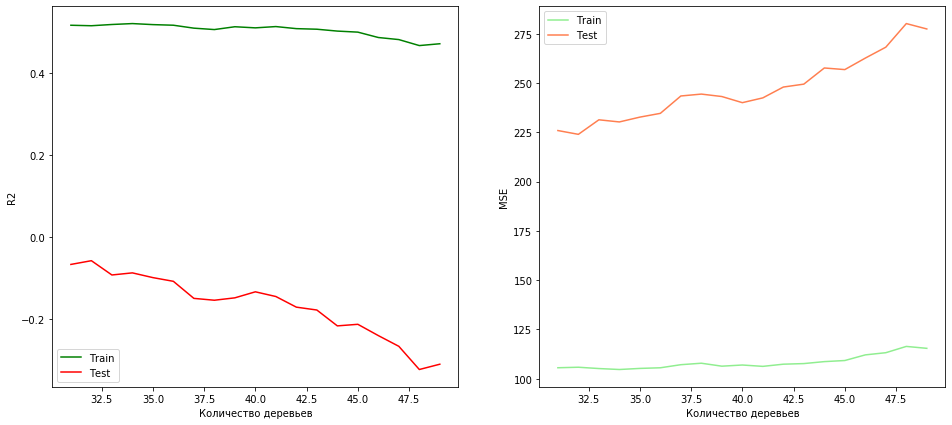

CPU times: user 27min 34s, sys: 8.82 s, total: 27min 43s
Wall time: 28min 17s


In [64]:
%%time
name = 'SGB'

a_depths = [5, 10, 100]
n_trees = 50
a_etas = [0.1, 0.01, 1]

for max_depth in a_depths:
    for eta in a_etas:
        params = [max_depth, eta]
        sboosting = StochasticGradientBoosting(n_trees=n_trees, max_depth=max_depth, eta=eta, size=0.5)
        sboosting.fit(X_train, y_train, X_valid, y_valid, get_err=True) 
        train_predictions_sgb = sboosting.predict(X_train)
        valid_predictions_sgb = sboosting.predict(X_valid)
        r2_train_sgb = r2_score(y_train, train_predictions_sgb)
        r2_test_sgb = r2_score(y_valid, valid_predictions_sgb)

        print(params, r2_test_sgb)
        if r2_test_sgb > 0.68533:
            print(f'{params} ok')
            model_name.append(name)
            model_params.append(params)
            r2_train_result.append(r2_train_sgb)
            r2_test_result.append(r2_test_sgb)
            mse_train_result.append(mean_squared_error(y_train, train_predictions_sgb))
            mse_test_result.append(mean_squared_error(y_valid, valid_predictions_sgb))
    
        plot_errors(list(range(31,n_trees)), sboosting.train_r2, sboosting.test_r2, sboosting.train_mse, sboosting.test_mse)    

In [65]:
models_results['model_name'] = model_name
models_results['r2_train_result'] = r2_train_result
models_results['r2_test_result'] = r2_test_result
models_results['mse_train_result'] = mse_train_result
models_results['mse_test_result'] = mse_test_result
models_results['model_params'] = model_params
models_results.sort_values(['r2_test_result'])

,model_name,r2_train_result,r2_test_result,mse_train_result,mse_test_result,model_params


Линейная модель показала совсем плохие результаты.<br>
Случайный лес показал лучшие результаты на деревьях с глубиной 100, но он переобучается.<br>
Градиентный бустинг показал лучший результат на деревьях с глубиной 5 и eta 0.1.<br>
Посмотрим еще на случайный лес с глубиной 25 и 50 и на градиентный бустинг 5/0.1 с бОльшим количеством деревьев и меньшим размером подвыборки.

25
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 25 R2 Train 0.6785351427224984
25 R2 Test 0.6434222603846773


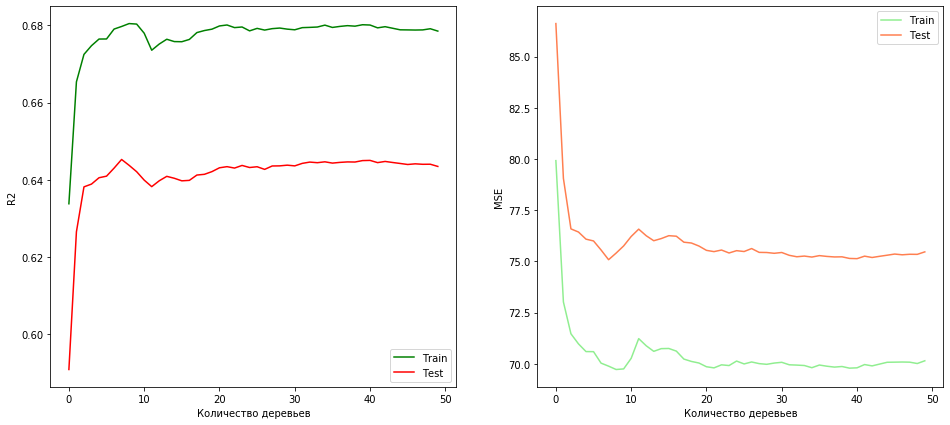

50
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 50 R2 Train 0.6810013623788006
50 R2 Test 0.6466597011425472


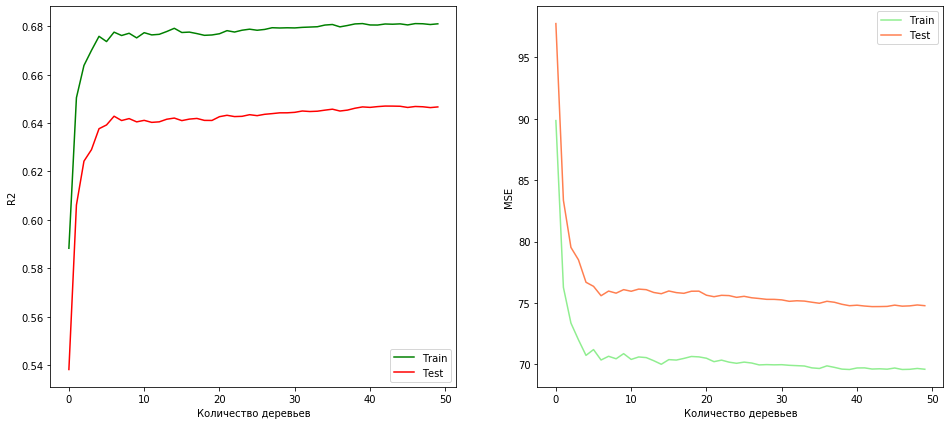

CPU times: user 4min 57s, sys: 3.51 s, total: 5min 1s
Wall time: 5min 12s


In [77]:
%%time
a_depths = [25, 50]
for depth in a_depths:
    print(depth)
    forest = RandomForest(n_trees=50, max_depth=depth)
    forest.fit(X_train, y_train, X_valid, y_valid, get_err=True) 
    train_predictions_f = forest.tree_vote(X_train)
    valid_predictions_f = forest.tree_vote(X_valid)
    r2_train_f = r2_score(y_train, train_predictions_f)
    r2_test_f = r2_score(y_valid, valid_predictions_f)

    print(f'{depth} R2 Train {r2_train_f}')
    print(f'{depth} R2 Test {r2_test_f}')
    
    plot_errors(list(range(50)), forest.train_r2, forest.test_r2, forest.train_mse, forest.test_mse)

In [79]:
forest.test_r2[5:10]

[0.6392161395450822,
 0.6428255749198251,
 0.641041797099536,
 0.6418409225684858,
 0.6404874584967033]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 R2 Train 0.6706387850737987
R2 Test 0.6445117040159596


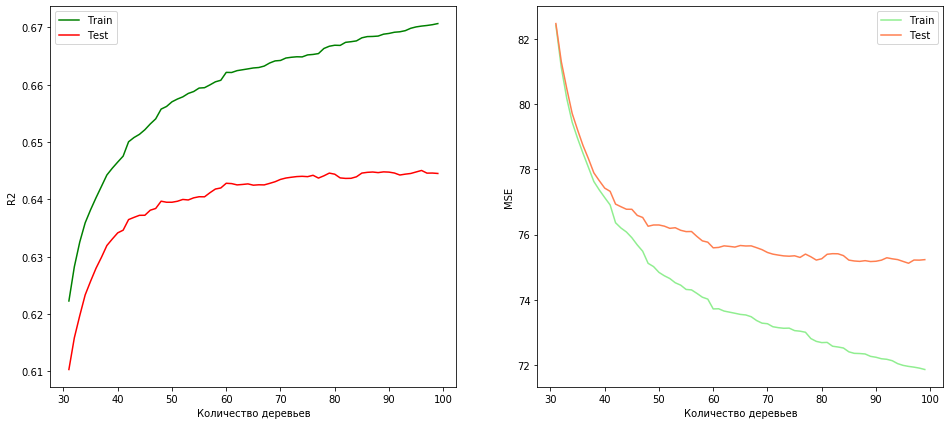

CPU times: user 4min 29s, sys: 1.89 s, total: 4min 30s
Wall time: 4min 42s


In [78]:
%%time
sboosting = StochasticGradientBoosting(n_trees=100, max_depth=5, eta=0.1, size=0.3)
sboosting.fit(X_train, y_train, X_valid, y_valid, get_err=True) 
train_predictions_sgb = sboosting.predict(X_train)
valid_predictions_sgb = sboosting.predict(X_valid)
r2_train_sgb = r2_score(y_train, train_predictions_sgb)
r2_test_sgb = r2_score(y_valid, valid_predictions_sgb)

print(f'R2 Train {r2_train_sgb}')
print(f'R2 Test {r2_test_sgb}')

plot_errors(list(range(31,100)), sboosting.train_r2, sboosting.test_r2, sboosting.train_mse, sboosting.test_mse)

In [80]:
sboosting.test_r2[30:51]

[0.6427439551237408,
 0.6425175235565573,
 0.6425953131171922,
 0.6426944331527793,
 0.6424681138692281,
 0.642535613219281,
 0.6425184042692519,
 0.6427837178559868,
 0.6430690442423823,
 0.643475748238431,
 0.6437168363908918,
 0.6438527796849336,
 0.6439691411073275,
 0.6440152438313257,
 0.6439547158611872,
 0.6441933962608115,
 0.6437080180338826,
 0.6441009549724693,
 0.644575226580425,
 0.644384319550706,
 0.6437368055990071]

Обучим весь набор данных на двух моделях: RandomForest(6,50) и StochasticGradientBoosting(48,5,0.1,0.3)

In [81]:
%%time
y = np.array(y)
forest = RandomForest(n_trees=6, max_depth=50)
forest.fit(X, y, X, y, get_err=False) 
train_predictions_f = forest.tree_vote(X)
r2_train_f = r2_score(y, train_predictions_f)
print(f'\nR2 Train {r2_train_f}')

1 2 3 4 5 6 
R2 Train 0.670423043075024
CPU times: user 4.9 s, sys: 158 ms, total: 5.06 s
Wall time: 5.3 s


In [82]:
test_pred = forest.tree_vote(test_norm)
test_pred[:15]

array([56.48069731, 62.44720257, 47.59163605, 85.33857573, 88.81724683,
       58.4665221 , 50.05939675, 55.02554056, 58.76049509, 79.02570025,
       52.6924841 , 60.01791228, 51.54383377, 82.71803201, 63.49474292])

In [83]:
# Записываем результат в файл
submission_data = pd.read_csv('regression-tutors-expected-math-exam-results/sample_submission.csv')
submission_data.head()

,Id,mean_exam_points
0,10000,50.0
1,10001,50.0
2,10002,50.0
3,10003,50.0
4,10004,50.0


In [84]:
submission_data['mean_exam_points'] = test_pred
submission_data.to_csv('regression-tutors-expected-math-exam-results/submissions/submission_1.csv', index=False)

**Результат на kaggle:** 0.96831

In [85]:
%%time
y = np.array(y)
sboosting = StochasticGradientBoosting(n_trees=48, max_depth=5, eta=0.1, size=0.3)
sboosting.fit(X, y, X, y, get_err=False) 
train_predictions_sgb = sboosting.predict(X)
r2_train_sgb = r2_score(y, train_predictions_sgb)
print(f'\nR2 Train {r2_train_sgb}')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 
R2 Train 0.6526936055690681
CPU times: user 19.1 s, sys: 167 ms, total: 19.2 s
Wall time: 19.2 s


In [86]:
test_pred = sboosting.predict(test_norm)
test_pred[:15]

array([54.92432856, 62.57620108, 52.01652595, 88.78316368, 87.68842604,
       57.08965667, 47.57697747, 53.86026626, 57.11108462, 78.43764939,
       51.92010359, 59.63214657, 50.24298496, 83.70425062, 64.01888565])

In [87]:
# Записываем результат в файл
submission_data = pd.read_csv('regression-tutors-expected-math-exam-results/sample_submission.csv')
submission_data.head()

,Id,mean_exam_points
0,10000,50.0
1,10001,50.0
2,10002,50.0
3,10003,50.0
4,10004,50.0


In [88]:
submission_data['mean_exam_points'] = test_pred
submission_data.to_csv('regression-tutors-expected-math-exam-results/submissions/submission_2.csv', index=False)

**Результат на kaggle:** 0.98289